In [1]:
### General analysis package
import os
import time
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### Drawing package
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
#import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # Output editable PDF text
### else
#import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # Error alert
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, average_precision_score

import math
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as TorchData
from torchmetrics import Accuracy
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings('ignore')

SEED = 42
seed_everything(SEED, workers=True)

print("Using torch", torch.__version__)

Global seed set to 42


42

Using torch 1.10.1


# 1. Knowledge network information（Mask）

In [3]:
microRNA = pd.read_csv('20220610_Results/1. diff_microRNA(FC2_FDR0.05).csv', index_col=0)['ID']

In [4]:
path = 'Breast cancer/'
### Target Gene
tar_data = pd.read_csv(path+'Target/hsa_MTI.csv')
mir2gene = {}
for i in tar_data.index:
    mir = str(tar_data.loc[i, 'miRNA']).strip()
    gene = str(tar_data.loc[i, 'Target Gene (Entrez Gene ID)']).strip()
    mir2gene[mir] = mir2gene.get(mir, set())
    mir2gene[mir].add(gene)
gene_set = set()
for mir in microRNA:
    gene_set.update(mir2gene.get(mir, set()))
GENE_LIST = list(gene_set)
GENE_MASK = []
for mir in microRNA:
    genes = mir2gene.get(mir, set())
    GENE_MASK.append([1 if g in genes else 0 for g in GENE_LIST])
GENE_MASK = torch.tensor(np.array(GENE_MASK).T, dtype=torch.float)
### Module
module_data = pd.read_csv(path+'KEGG/gene2module.txt', sep='\t')
gene2module = {}
for i in module_data.index:
    mid = str(module_data.loc[i, 'Module']).split('hsa_')[1].strip()
    gene = str(module_data.loc[i, 'gene']).split('hsa:')[1].strip()
    gene2module[gene] = gene2module.get(gene, set())
    gene2module[gene].add(mid)
module_set = set()
for gene in GENE_LIST:
    module_set.update(gene2module.get(gene, set()))
MODULE_LIST = list(module_set)
MODULE_MASK = []
for gene in GENE_LIST:
    modules = gene2module.get(gene, set())
    MODULE_MASK.append([1 if m in modules else 0 for m in MODULE_LIST])
MODULE_MASK = torch.tensor(np.array(MODULE_MASK).T, dtype=torch.float)
### Pathway
pathway_data = pd.read_csv(path+'KEGG/module2pathway.txt', sep='\t')
module2pathway = {}
for i in pathway_data.index:
    pathway = str(pathway_data.loc[i, 'Pathway']).split('path:')[1].strip()
    module = str(pathway_data.loc[i, 'Module']).split('md:')[1].strip()
    module2pathway[module] = module2pathway.get(module, set())
    module2pathway[module].add(pathway)
pathway_set = set()
for module in MODULE_LIST:
    pathway_set.update(module2pathway.get(module, set()))
PATHWAY_LIST = list(pathway_set)

PATHWAY_MASK = []
for module in MODULE_LIST:
    pathways = module2pathway.get(module, set())
    PATHWAY_MASK.append([1 if p in pathways else 0 for p in PATHWAY_LIST])
PATHWAY_MASK = torch.tensor(np.array(PATHWAY_MASK).T, dtype=torch.float)

Constructing neural network model based on knowledge information

In [5]:
class MaskedModel(LightningModule):
    def __init__(self, mirN, geneN, gene_mask, moduleN, module_mask, pathwayN, pathway_mask, learning_rate):
        super(MaskedModel, self).__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        # microRNA 2 Gene
        self.mir2gene = nn.Linear(mirN, geneN)
        self.mir2gene.weight.data = self.mir2gene.weight * gene_mask
        self.gene_mask = gene_mask
        self.gene_active = nn.ReLU() # ReLU Tanh
        self.gene_bn = nn.BatchNorm1d(geneN, eps=1e-05, momentum=0.5, affine=True)
        self.gene_dropout = nn.Dropout(p=0.8)
        
        ## Gene 2 Module
        self.gene2module = nn.Linear(geneN, moduleN)
        self.gene2module.weight.data = self.gene2module.weight * module_mask
        self.module_mask = module_mask
        self.module_active = nn.ReLU()
        self.module_bn = nn.BatchNorm1d(moduleN, eps=1e-05, momentum=0.5, affine=True)
        self.module_dropout = nn.Dropout(p=0.5)
        
        ## Module 2 Pathway
        self.module2pathway = nn.Linear(moduleN, pathwayN)
        self.module2pathway.weight.data = self.module2pathway.weight * pathway_mask
        self.pathway_mask = pathway_mask
        self.pathway_active = nn.ReLU()
        self.pathway_bn = nn.BatchNorm1d(pathwayN, eps=1e-05, momentum=0.5, affine=True)
        self.pathway_dropout = nn.Dropout(p=0.2)
        
        ## Output
        self.pathway2out = nn.Linear(pathwayN, 2)
        self.out_bn = nn.BatchNorm1d(2, eps=1e-05, momentum=0.5, affine=True)
        #self.sigmoid = nn.Sigmoid()
        
        # Result save
        self.gene_result = None
        self.module_result = None
        self.pathway_result = None
    
    def forward(self, x):
        ## microRNA 2 Gene
        #print(self.mir2gene.weight.data.shape, self.mir2gene.weight.shape, self.gene_mask.shape)
        self.mir2gene.weight.data = self.mir2gene.weight * self.gene_mask
        #print(self.mir2gene.weight.data.shape)
        gene_x = self.mir2gene(x)
        gene_x = self.gene_active(gene_x)
        gene_x = self.gene_bn(gene_x)
        gene_x = self.gene_dropout(gene_x)
        self.gene_result = gene_x # save result
        
        ## Gene 2 Module
        self.gene2module.weight.data = self.gene2module.weight * self.module_mask
        module_x = self.gene2module(gene_x)
        module_x = self.module_active(module_x)
        module_x = self.module_bn(module_x)
        module_x = self.module_dropout(module_x)
        self.module_result = module_x # save result
        
        ## Module 2 Pathway
        self.module2pathway.weight.data = self.module2pathway.weight * self.pathway_mask
        pathway_x = self.module2pathway(module_x)
        pathway_x = self.pathway_active(pathway_x)
        pathway_x = self.pathway_bn(pathway_x)
        pathway_x = self.pathway_dropout(pathway_x)
        self.pathway_result = pathway_x # save result
        
        ## Output
        out_x = self.pathway2out(pathway_x)
        out_x = self.out_bn(out_x)
        #out_x = self.sigmoid(out_x)
        return out_x
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self.forward(x), y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = F.softmax(self(x))
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = logits[:, 1]
        auc = roc_auc_score(y, probs)
        bac = balanced_accuracy_score(y, preds)
        aps = average_precision_score(y, probs)
        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        #self.auc(probs, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_bac", bac, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)
        self.log("val_aps", aps, prog_bar=True)
        self.log("val_rec", recall, prog_bar=True)
        self.log("val_pre", precision, prog_bar=True)
        return loss
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack(validation_step_outputs).mean()
        #avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean() # Outputs are the values of return for validation
        self.logger.experiment.add_scalar('loss', avg_loss, self.current_epoch)
    
    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = F.softmax(self(x))
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = logits[:, 1]
        return preds, probs
    

# 3. Model Initialization

In [6]:
mirN = len(microRNA)
geneN = len(GENE_LIST)
moduleN = len(MODULE_LIST)
pathwayN = len(PATHWAY_LIST)
print(mirN, geneN, moduleN, pathwayN)
GENE_No_MASK = torch.ones_like(GENE_MASK)
MODULE_No_MASK = torch.ones_like(MODULE_MASK)
PATHWAY_No_MASK = torch.ones_like(PATHWAY_MASK)
model = MaskedModel(mirN, geneN, GENE_MASK, moduleN, MODULE_MASK, pathwayN, PATHWAY_MASK, 0.01)

710 11418 116 70


In [7]:
print(model)

MaskedModel(
  (mir2gene): Linear(in_features=710, out_features=11418, bias=True)
  (gene_active): ReLU()
  (gene_bn): BatchNorm1d(11418, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (gene_dropout): Dropout(p=0.8, inplace=False)
  (gene2module): Linear(in_features=11418, out_features=116, bias=True)
  (module_active): ReLU()
  (module_bn): BatchNorm1d(116, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (module_dropout): Dropout(p=0.5, inplace=False)
  (module2pathway): Linear(in_features=116, out_features=70, bias=True)
  (pathway_active): ReLU()
  (pathway_bn): BatchNorm1d(70, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (pathway_dropout): Dropout(p=0.2, inplace=False)
  (pathway2out): Linear(in_features=70, out_features=2, bias=True)
  (out_bn): BatchNorm1d(2, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
)


In [8]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter mir2gene.weight, shape torch.Size([11418, 710])
Parameter mir2gene.bias, shape torch.Size([11418])
Parameter gene_bn.weight, shape torch.Size([11418])
Parameter gene_bn.bias, shape torch.Size([11418])
Parameter gene2module.weight, shape torch.Size([116, 11418])
Parameter gene2module.bias, shape torch.Size([116])
Parameter module_bn.weight, shape torch.Size([116])
Parameter module_bn.bias, shape torch.Size([116])
Parameter module2pathway.weight, shape torch.Size([70, 116])
Parameter module2pathway.bias, shape torch.Size([70])
Parameter pathway_bn.weight, shape torch.Size([70])
Parameter pathway_bn.bias, shape torch.Size([70])
Parameter pathway2out.weight, shape torch.Size([2, 70])
Parameter pathway2out.bias, shape torch.Size([2])
Parameter out_bn.weight, shape torch.Size([2])
Parameter out_bn.bias, shape torch.Size([2])


# 4. Data import¶

In [9]:
X_train = pd.read_csv('20220610_Results/1. X_train.csv', index_col=0)
X_test = pd.read_csv('20220610_Results/1. X_test.csv', index_col=0)
y_train = pd.read_csv('20220610_Results/1. y_train.csv', index_col=0)
y_test = pd.read_csv('20220610_Results/1. y_test.csv', index_col=0)

cv = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=.4, random_state=SEED)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in cv.split(X, y):pass
X_train, X_valid = X.iloc[train_index, :], X.iloc[val_index, :]
y_train, y_valid = y.iloc[train_index], y.iloc[val_index]

# Normalize ?
scaler = Normalizer() # Normalizer StandardScaler
X_train = pd.DataFrame(scaler.fit_transform(X_train[microRNA]), index=X_train.index, columns=microRNA)
X_valid = pd.DataFrame(scaler.fit_transform(X_valid[microRNA]), index=X_valid.index, columns=microRNA)
X_test = pd.DataFrame(scaler.fit_transform(X_test[microRNA]), index=X_test.index, columns=microRNA)
############

X_train = torch.from_numpy(X_train.values).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train['Label'].values).type(torch.LongTensor)
X_valid = torch.from_numpy(X_valid.values).type(torch.FloatTensor)
y_valid = torch.from_numpy(y_valid['Label'].values).type(torch.LongTensor)
X_test = torch.from_numpy(X_test.values).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test['Label'].values).type(torch.LongTensor)

In [10]:
train_data_loader = TorchData.DataLoader(dataset=TorchData.TensorDataset(X_train, y_train), 
                                         batch_size=64, shuffle=True)

valid_data_loader = TorchData.DataLoader(dataset=TorchData.TensorDataset(X_valid, y_valid), 
                                         batch_size=64, shuffle=True)

test_data_loader = TorchData.DataLoader(dataset=TorchData.TensorDataset(X_test, y_test), 
                                        batch_size=X_test.shape[0], shuffle=False)

# 5. Train

In [11]:
logger = TensorBoardLogger("tb_logs", name="BioNet_nor")
# Initialize a trainer
trainer = Trainer(
    accelerator="cpu",
    #gpus=AVAIL_GPUS,
    num_processes=1,
    min_epochs=10,
    max_epochs=500,
    #progress_bar_refresh_rate=20,
    callbacks=[EarlyStopping(monitor="val_auc", mode='max')], # validate Stops when the AUC in the data is highest
    auto_lr_find=True,
    stochastic_weight_avg=False,
    #deterministic=False, # GPU repeatable
    #val_check_interval=100,
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
# tune the model (batch_size, lr_find)
#trainer.tune(model, train_data_loader, valid_data_loader)

In [13]:
# Train the model
trainer.fit(model, train_data_loader, valid_data_loader)
trainer.save_checkpoint("Temp/BioNet_nor.ckpt")


   | Name            | Type        | Params
-------------------------------------------------
0  | mir2gene        | Linear      | 8.1 M 
1  | gene_active     | ReLU        | 0     
2  | gene_bn         | BatchNorm1d | 22.8 K
3  | gene_dropout    | Dropout     | 0     
4  | gene2module     | Linear      | 1.3 M 
5  | module_active   | ReLU        | 0     
6  | module_bn       | BatchNorm1d | 232   
7  | module_dropout  | Dropout     | 0     
8  | module2pathway  | Linear      | 8.2 K 
9  | pathway_active  | ReLU        | 0     
10 | pathway_bn      | BatchNorm1d | 140   
11 | pathway_dropout | Dropout     | 0     
12 | pathway2out     | Linear      | 142   
13 | out_bn          | BatchNorm1d | 4     
-------------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
37.897    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# 6. Model evaluation

In [14]:
trainer.test(model, valid_data_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_aps            0.9546261634744474
         val_auc            0.9789379339918536
         val_bac            0.9303844927249523
        val_loss            0.38233035802841187
         val_pre            0.9286368549529922
         val_rec             0.891633885396414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.38233035802841187,
  'val_bac': 0.9303844927249523,
  'val_auc': 0.9789379339918536,
  'val_aps': 0.9546261634744474,
  'val_rec': 0.891633885396414,
  'val_pre': 0.9286368549529922}]

In [15]:
trainer.test(model, test_data_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_aps            0.9572682644262971
         val_auc            0.9782986111111109
         val_bac            0.9415664269179894
        val_loss            0.3778093159198761
         val_pre            0.9507186858316222
         val_rec                0.904296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3778093159198761,
  'val_bac': 0.9415664269179894,
  'val_auc': 0.9782986111111109,
  'val_aps': 0.9572682644262971,
  'val_rec': 0.904296875,
  'val_pre': 0.9507186858316222}]

Predicting: 24it [00:00, ?it/s]

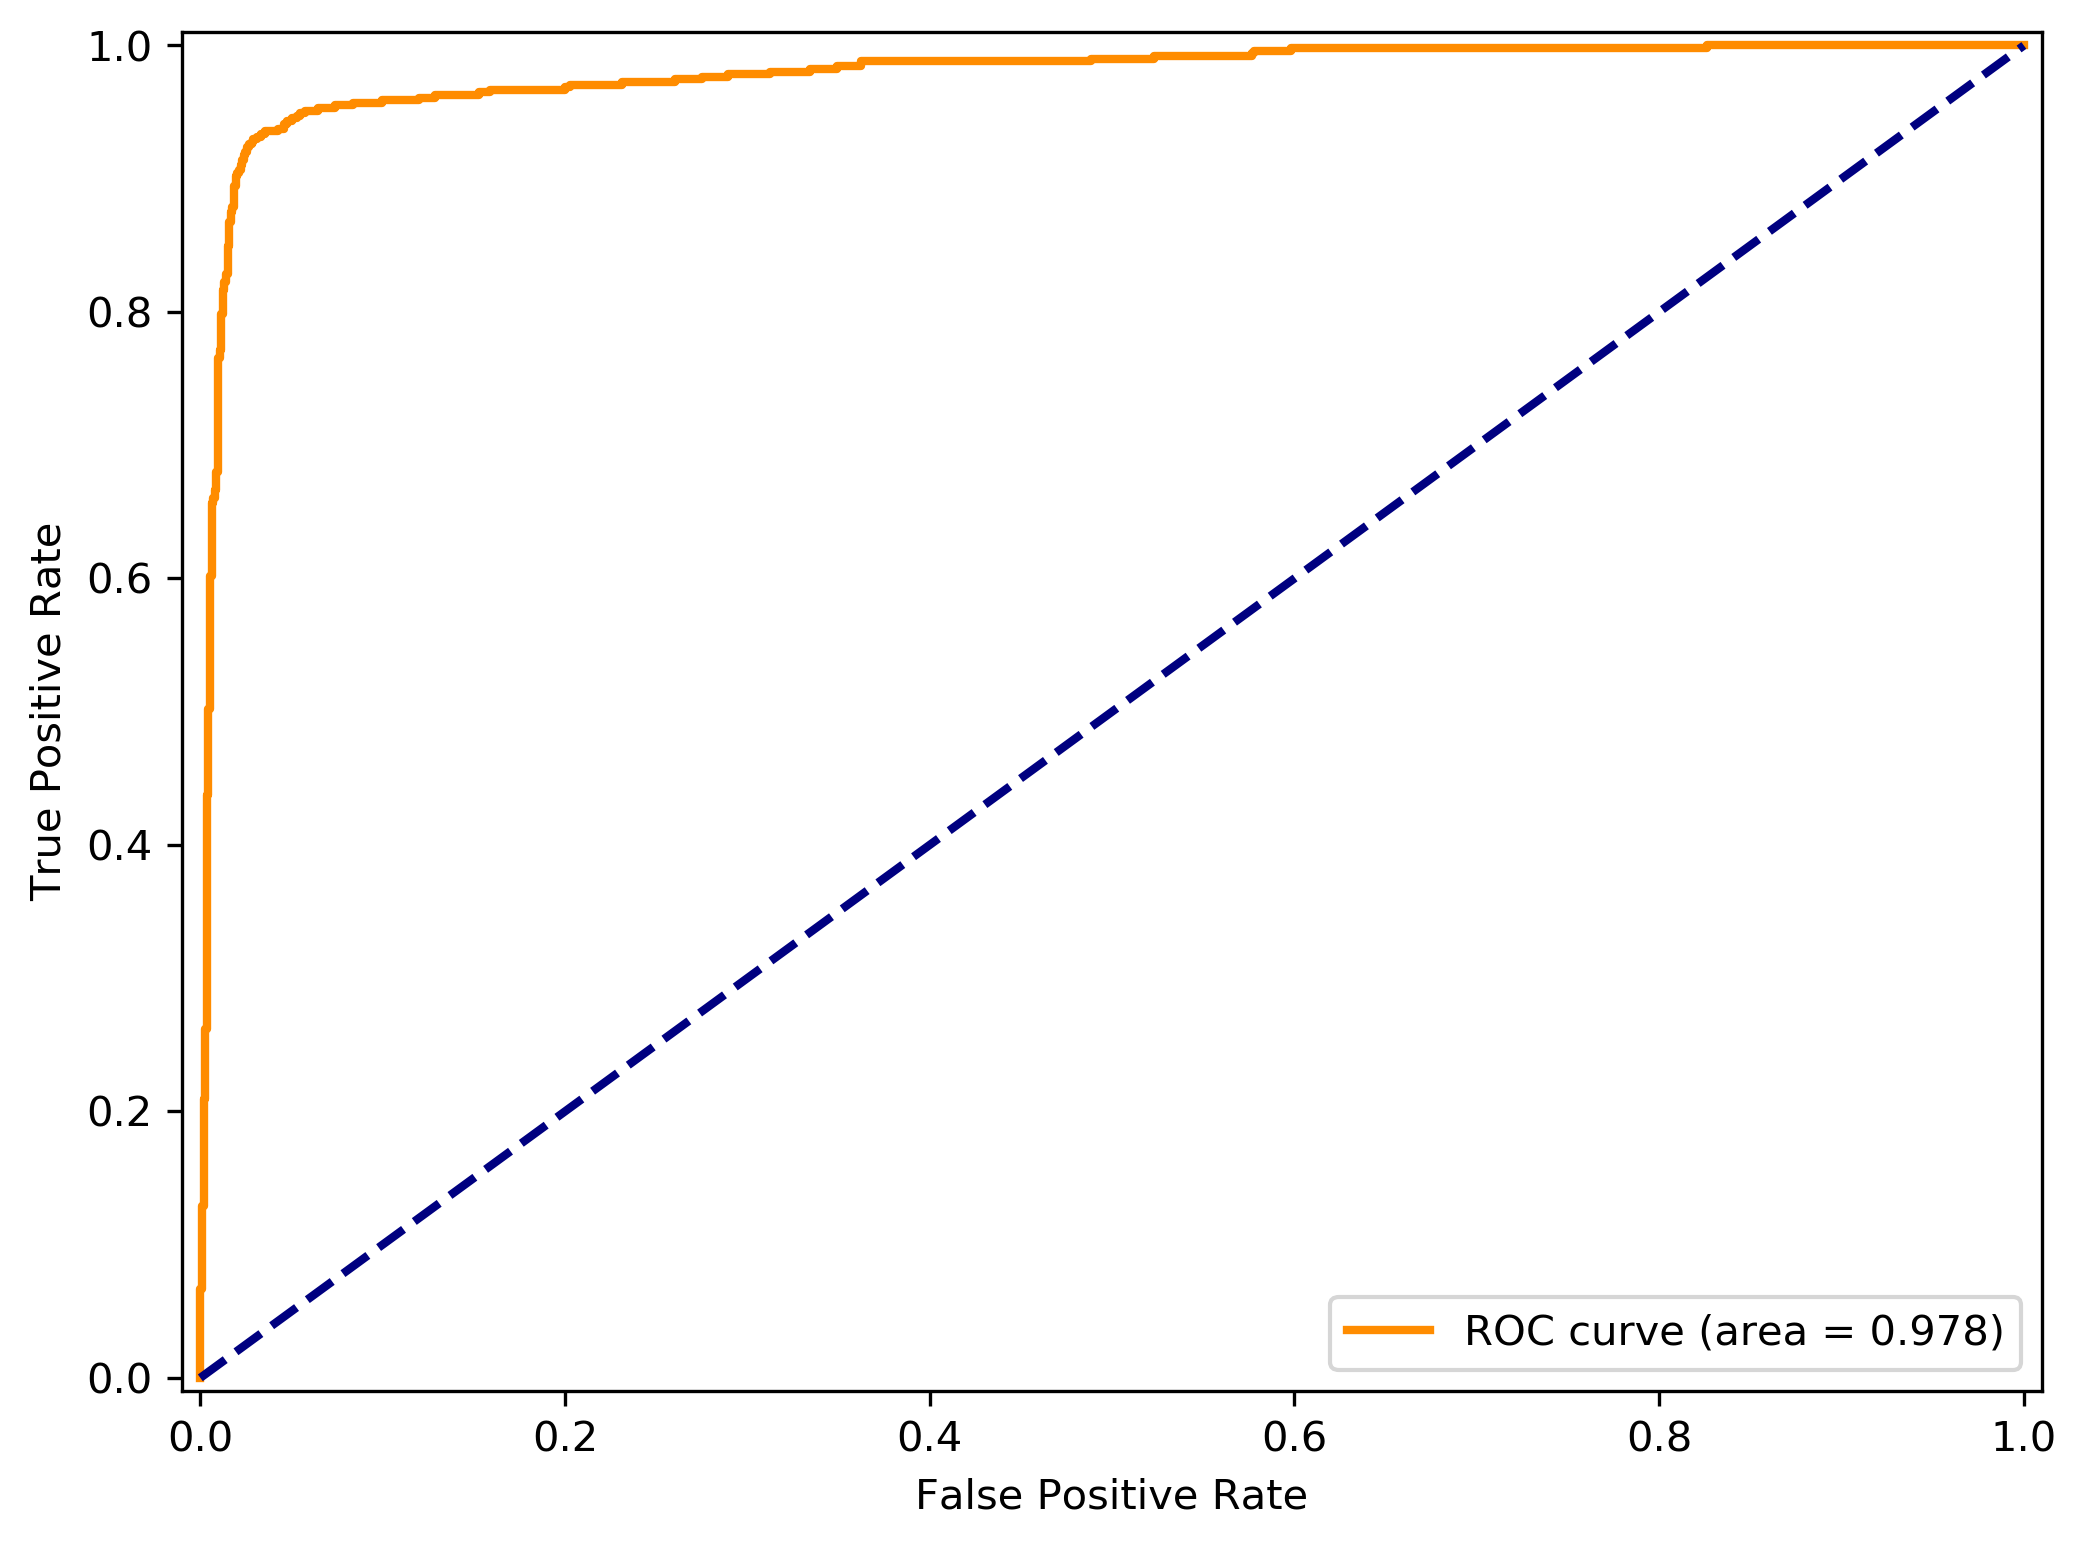

<Figure size 2400x1800 with 0 Axes>

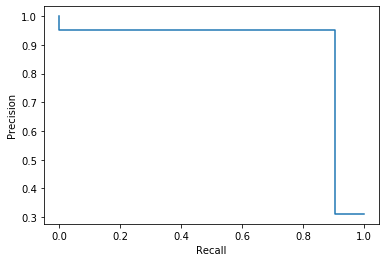

In [16]:
from sklearn import metrics
pred, probs = trainer.predict(model, test_data_loader)[0]
#auc = roc_auc_score(y_test, probs.numpy())

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs.numpy(), pos_label=1)
auc = metrics.auc(fpr, tpr)
fig = plt.figure(figsize=(8, 6), dpi=300)
_ = plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.3f)" % auc)
_ = plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
_ = plt.xlim([-0.01, 1.01])
_ = plt.ylim([-0.01, 1.01])
_ = plt.xlabel("False Positive Rate")
_ = plt.ylabel("True Positive Rate")
_ = plt.legend(loc="lower right")
_ = plt.show()
#fig.savefig('20220610_Results/6. ROC.pdf', dpi=300)

precision, recall, _ = metrics.precision_recall_curve(y_test, pred.numpy())
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
fig = plt.figure(figsize=(8, 6), dpi=300)
_ = disp.plot()

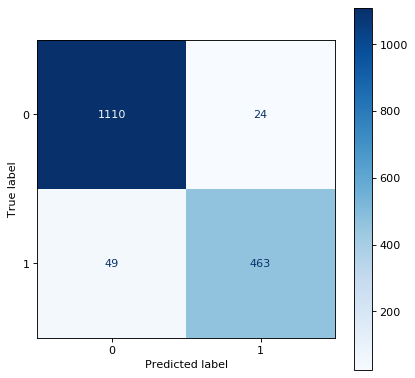

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(1, (6, 6), dpi=80)
ax = fig.add_subplot(1,1,1)
cm = confusion_matrix(y_test, pred.numpy(), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
_ = disp.plot(ax=ax, cmap='Blues') #, ax=ax, cmap='Blues'
#_ = plot_confusion_matrix(model, X_test[select_microRNA], y_test, ax=ax, cmap='Blues')
#fig.savefig('20220610_Results/6. plot_confusion_matrix.pdf', dpi=300)

# 7. Model predictions

In [18]:
model = MaskedModel.load_from_checkpoint(checkpoint_path="Temp/BioNet_nor.ckpt")
trainer = Trainer()
#trainer.test(model, dataloaders=test_data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
#trainer.predict(model, test_data_loader)

Predicting: 0it [00:00, ?it/s]

[(tensor([0, 0, 0,  ..., 0, 0, 1]),
  tensor([0.0013, 0.0015, 0.0017,  ..., 0.0298, 0.0137, 0.8717]))]

# 8. External data validation

In [20]:
extenal = pd.read_csv('20220610_Results/1. GSE58606.csv', index_col=0)
X_train_ = pd.read_csv('20220610_Results/1. X_train.csv', index_col=0)
len(microRNA), len(set(microRNA)&set(extenal.columns))
extenal.head(2)
temp = extenal[list(set(microRNA)&set(extenal.columns))+['Label']]
for i in set(microRNA)-set(extenal.columns):
    temp[i] = X_train_[i].median()
extenal = temp
extenal.head(2)

scaler = Normalizer() # Normalizer StandardScaler
X_extenal = pd.DataFrame(scaler.fit_transform(extenal[microRNA]), index=extenal.index, columns=microRNA)
y_extenal = extenal['Label'].values

(710, 523)

,hsa-miR-9-5p,hsa-miR-126-3p,hsa-miR-140-5p,hsa-miR-105-5p,hsa-miR-297,hsa-let-7i-5p,hsa-miR-130a-3p,hsa-miR-146b-5p,hsa_negative_control_6,hsa_negative_control_7,...,hsa-miR-205-3p,hsa-miR-1260a,hsa-miR-525-5p,hsa-miR-187-5p,hsa-miRPlus-A1086,hsa-miR-551b-5p,hsa-miR-300,hsa-miR-193b-5p,Label,Disease
0,6.877643,8.080215,6.245265,6.304782,6.686064,7.805950,6.814781,7.146955,6.170680,6.129586,...,7.176684,7.724408,6.035476,6.255048,6.572019,6.251777,5.873303,6.362097,1,primary breast cancer
1,6.544287,6.882722,5.874236,6.324987,6.638048,6.946567,6.488574,6.690773,6.160272,6.104929,...,7.249094,7.308890,6.021796,6.902473,6.347183,6.625569,6.004899,6.560329,1,primary breast cancer


,hsa-miR-875-5p,hsa-miR-99a-3p,hsa-miR-196b-5p,hsa-miR-4456,hsa-miR-5004-5p,hsa-miR-526b-5p,hsa-miR-122-5p,hsa-miR-708-3p,hsa-miR-4510,hsa-miR-616-5p,...,hsa-miR-1288-5p,hsa-miR-6772-3p,hsa-miR-504-5p,hsa-miR-6826-5p,hsa-miR-7160-3p,hsa-miR-8064,hsa-miR-376a-2-5p,hsa-miR-6818-5p,hsa-miR-8063,hsa-miR-8059
0,6.097826,6.454512,6.527494,10.28918,6.896914,6.374826,6.323629,6.332212,6.353440,6.391591,...,2.403726,3.414851,2.501417,6.348159,2.389214,3.867423,2.359387,2.45412,7.677084,8.266604
1,6.073248,6.361881,6.369383,10.73224,7.435074,6.320196,6.310753,6.310753,6.758494,6.439965,...,2.403726,3.414851,2.501417,6.348159,2.389214,3.867423,2.359387,2.45412,7.677084,8.266604


In [21]:
X_extenal = torch.from_numpy(X_extenal.values).type(torch.FloatTensor)
y_extenal = torch.from_numpy(y_extenal).type(torch.LongTensor)
extenal_data_loader = TorchData.DataLoader(dataset=TorchData.TensorDataset(X_extenal, y_extenal), 
                                           batch_size=X_extenal.shape[0], shuffle=False)

In [22]:
trainer.test(model, extenal_data_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_aps             0.859599039165206
         val_auc            0.19597615499254845
         val_bac                    0.5
        val_loss            0.40964600443840027
         val_pre            0.9172932330827067
         val_rec                    1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.40964600443840027,
  'val_bac': 0.5,
  'val_auc': 0.19597615499254845,
  'val_aps': 0.859599039165206,
  'val_rec': 1.0,
  'val_pre': 0.9172932330827067}]

In [23]:
trainer.predict(model, extenal_data_loader)

Predicting: 0it [00:00, ?it/s]

[(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([0.9642, 0.9543, 0.9511, 0.9670, 0.9823, 0.9789, 0.9857, 0.9737, 0.9791,
          0.9666, 0.9684, 0.9644, 0.9640, 0.9684, 0.9746, 0.9664, 0.9562, 0.9557,
          0.9524, 0.9511, 0.9500, 0.9529, 0.9512, 0.9617, 0.9494, 0.9586, 0.9589,
          0.9629, 0.9551, 0.9487, 0.9592, 0.9612, 0.9625, 0.9533, 0.9638, 0.9621,
          0.9643, 0.9538, 0.9642, 0.9607, 0.9597, 0.9667, 0.9696, 0.9606, 0.9629,
          0.9567, 0.9643, 0.9659, 0.9662, 0.9674, 0.9666, 0.9790, 0.9772, 0.9768,
          0.9799, 0.9831, 0.9652, 0.9734, 0.984